# Daily News for Stock Market Prediction - Part II<a name="breakdown"></a>

In this project, we will create a classifier that can predict stock market movement based on daily news headlines. At this part, we mainly will implement Logistic regression and bring in some important tools like loss funtions and the way to minimize it. 

Before get started, make sure to have gone through the part I since we will use the outcome and methods illustrated in it.

Here's the phase breakdown of the part I:

[Phase1: Empirical Probability](#phase1)  
[Phase2: Sigmoid Function](#phase2)  
[Phase3: KL Divergence](#phase3)  
[Phase4: Cross Entropy Loss](#phase4)  
[Phase5: Gradient Descent](#phase5)  

In [1]:
import numpy as np
import pandas as pd
import sklearn.datasets
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.tools as tools
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
combined_data = pd.read_csv('data/Combined_News_DJIA.csv')
data = combined_data.iloc[:, 0:22]
data.head(1)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir..."


## Empirical Probability<a name="phase1"></a> 
[Return to phase breakdown](#breakdown)

We all know that fitting a model requires three components: a model that makes predictions, a loss function, and an optimization method. To better understand the logistic model, we will firstly use another classic classification example from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) to help us illustrate and make the next step. 

The data we will use is Wisconsin Breast Cancer Dataset which we can obtain from [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). This is a pretty famous and very easy binary classification problem, you can also find it in [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/home). We will use the data to predict whether it is **malignant** or not, more over we only will use `mean radius` this single feature. Here is the dataset:

In [3]:
wbc_dict = sklearn.datasets.load_breast_cancer()
wbcdata = pd.DataFrame(wbc_dict['data'], columns=wbc_dict['feature_names'])
wbcdata['malignant'] = (wbc_dict['target']==0)
wbcdata = wbcdata.loc[:, ['mean radius', 'malignant']]
wbcdata.head()

,mean radius,malignant
0,17.99,True
1,20.57,True
2,19.69,True
3,11.42,True
4,20.29,True


We will define $X$ and $Y$ as variables containing the training features("mean radius") and labels("malignant").

In [4]:
X = wbcdata[['mean radius']].values
Y = wbcdata['malignant'].values.astype(float)

In [5]:
# Since raw data labels are only 0s and 1s, we can improve the plot by jittering the data.
jitter_y = Y + 0.1*np.random.rand(len(Y)) - 0.05 
ind_mal = Y == True

mal_points = go.Scatter(name="Classified as Malignant", 
                        x=np.squeeze(X[ind_mal]), y=jitter_y[ind_mal],
                        mode="markers", marker=dict(opacity=0.5, color="red"))
ben_points = go.Scatter(name="Classified as Benign", 
                        x=np.squeeze(X[~ind_mal]), y=jitter_y[~ind_mal],
                        mode="markers", marker=dict(opacity=0.5, color="blue"))
layout = {'xaxis':{'title':"mean radius"}, 'yaxis':{'title':"Malignant"}}
py.iplot(go.Figure([mal_points, ben_points], layout = layout))

Apparently, we want to constrain our $f_\theta(X) $ so that its output can be interpreted as a probability and make a simple decision rule like:

$$ \text{If } f_\theta(x) > 0.5 \text{ predict 1 (malignant) else predict 0 (benign).} $$

This means that it may only output values in the range $[0,1]$. In addition, we would like large values of $f_\theta(X)$ to correspond to high probabilities and small values to low probabilities, considering following example:

In [6]:
X_slices = np.linspace(8,24,10)
Y_emp = [np.mean(Y[np.squeeze(np.abs(X-c)) < 1]) for c in X_slices]

P_emp_line = go.Scatter(name="Empirical Probabilities", x=X_slices, y=Y_emp, 
                        mode="lines", line={'color':"green", 'width':6})

py.iplot(go.Figure(data=[mal_points, ben_points, P_emp_line], layout=layout))

In our case, we evenly choose ten points from range $[8,24]$ as our observation samples, and choose the points in $Y$ which absolute distance from it are less than 1, take the mean and get the likelihood of malignancy of sample points. 

This is [Empirical Probability](https://en.wikipedia.org/wiki/Empirical_probability), which is the ratio of the number of outcomes in which a specified event occurs to the total number of trials, not in a theoretical sample space but in an actual experiment. In a more general sense, empirical probability estimates probabilities from experience and observation, based upon previous evidence or experimental results. To accomplish this, we finally introduce the logistic funtion, often called the sigmoid function.

## Sigmoid Function<a name="phase2"></a> 
[Return to phase breakdown](#breakdown)

The logistic function (sometimes called the sigmoid function) has the above shape and is commonly used to transform a real number into a value that can be used to encode a probability. The logistic function has some interesting mathematical properties but let's start with it's form:

$$\large \sigma(t) = \frac{1}{1 + e^{-t}} $$

In [7]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

In [8]:
t = np.linspace(-5,5,50)
sigmoid_line = go.Scatter(name="Logistic Function", x=t, y=sigmoid(t), mode="lines")
layout = {'xaxis':{'title':'t'}, 'yaxis':{'title':r"$\sigma(t)$"}}
py.iplot(go.Figure([sigmoid_line], layout=layout))

Observe that sigmoid function $\sigma(t)$ takes in any real number $R$ and outputs only numbers in range $(0,1)$. The function is monotonically increasing on its input $t$, large values of $t$ correspond to values closer to 1, as desired. 

We can also make an interactive sigmoid function $\sigma(wt)$:

In [9]:
t = np.linspace(-5,5,50)
lines = []
for w in np.linspace(0.5,10,20):
    line = go.Scatter(name=str(w), x=t, y=sigmoid(w*t), mode="lines", visible=False)
    lines.append(line)
lines[0].visible = True

steps = []
for i in range(len(lines)):
    step = {'label':lines[i]['name'], 'method':'restyle', 'args':['visible', [False]*len(lines)]}
    step['args'][1][i] = True
    steps.append(step)

sliders = {'active':0, 'currentvalue':{"prefix":"scale term: "}, 'steps':steps}
layout = {'xaxis':{'range':[t.min(),t.max()]}, 'yaxis':{'range':[0,1]},
          'showlegend':True, 'sliders':[sliders]}

py.iplot(go.Figure(data=lines, layout=layout))

## KL Divergence <a name="phase3"></a> 
[Return to phase breakdown](#breakdown)

After model selection, next step we should do is to address the problem of defining a loss function for this model that allows us to fit the model's parameters to data. Since logistic regression outputs probabilities, a logistic model produces a certain type of probability distribution. Specifically, based on optimal parameters $\hat{\theta}$, it estimates the probability that the label $y$ is 1 for an example input $x$.

For example, in our Wisconsin Breast Cancer example, suppose $x$ is a scalar meaning mean radius of cell nuclei from a breast mass and $y=1$ means this case is malignant, a logistic model with scalar parameter $\hat{\theta}$ predicts the probability that this case is malignant given the mean radius of cell nuclei from that breast mass: $\hat{P_\theta}(y=1|x)$.

Collecting data on multiple cases provides us with a method of constructing an empirical probability distribution.  We can compute a similar probability distribution for each value of $x$ that appears in our data. Naturally, after fitting a logistic model we would like the distribution predicted by the model to be as close as possible to the empirical distribution from the dataset. That is, for all values of $x$ that appear in our data, we want:

$$ \hat{\mathbf{P}}_\theta(y = 1\, | \, x) \approx \mathbf{P}(y = 1\, | \, x)$$

One commonly used metric to determine "similarites" of two probability distributions is [KL(Kullback–Leibler) divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) (also called relative entropy) given by:

$$ \Large \textbf{D}(P || Q) = \sum_{k=1}^K P(k) \log \left( \frac{P(k)}{Q(k)} \right) $$

The following computes the KL divergence between two categorical distributions:

In [10]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

Evaluating two distributions:

In [11]:
p = np.array([2, 1, 3, 3, 2, 3, 1, 1, 3, 2, 1, 2, 1, 3, 3])
p = p / p.sum()
q = np.array([1, 2, 1, 1, 1, 1, 3, 1, 2, 3, 1, 3, 3, 3, 2])
q = q / q.sum()
print("Distribution of p: \n", p)
print("\nDistribution of q: \n", q)

Distribution of p: 
 [0.06451613 0.03225806 0.09677419 0.09677419 0.06451613 0.09677419
 0.03225806 0.03225806 0.09677419 0.06451613 0.03225806 0.06451613
 0.03225806 0.09677419 0.09677419]

Distribution of q: 
 [0.03571429 0.07142857 0.03571429 0.03571429 0.03571429 0.03571429
 0.10714286 0.03571429 0.07142857 0.10714286 0.03571429 0.10714286
 0.10714286 0.10714286 0.07142857]


Visualizing the KL divergence:

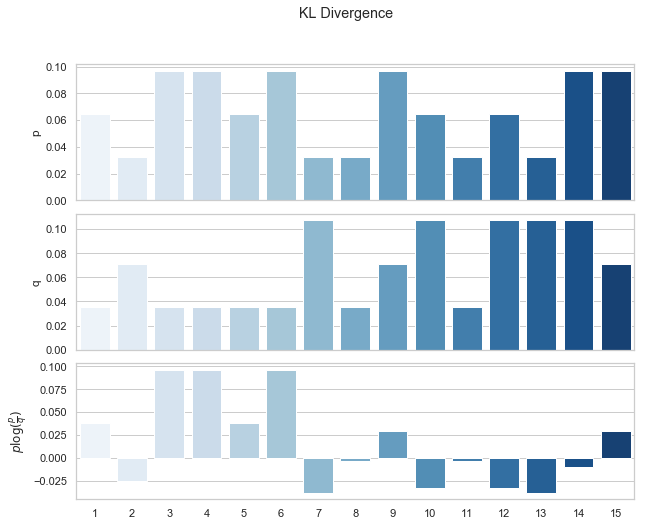

In [12]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=3, figsize=(10, 8))
classes = np.arange(len(p)) + 1
sns.barplot(x=classes, y=p, ax=axs[0], palette = 'Blues')
axs[0].set(ylabel='p')
axs[0].xaxis.set_visible(False)

sns.barplot(x=classes, y=q, ax=axs[1], palette = 'Blues')
axs[1].set(ylabel='q')
axs[1].xaxis.set_visible(False)

sns.barplot(x=classes, y=p*np.log(p/q), ax=axs[2], palette = 'Blues')
axs[2].set(ylabel=r"$p\log(\frac{p}{q})$")

plt.subplots_adjust(hspace=0.1)
fig.suptitle('KL Divergence');

Notice

1. KL divergence is larger when P is big and P does not match Q. Where P is small (unlikely events) Q does not need to match P.
2. KL divergence is not symmetric, i.e. the divergence of P from Q is not the same as the divergence of Q from P: 
$$D_{KL}(P\;||\;Q) \ne D_{KL}(Q\;||\;P)$$
3. KL divergence is non-negative, $D_{KL}(P\;||\;Q) \geq 0$: known as [Gibbs' inequality](https://en.wikipedia.org/wiki/Gibbs%27_inequality), with $D_{KL}(P\;||\;Q)=0$ if and only if $P=Q$ almost everywhere.
4. KL divergence is [convex](https://en.wikipedia.org/wiki/Convex_function) in the pair of probability mass functions (p,q) (like the above example we have given), i.e. if (p1,q1) and (p2,q2) are two pairs of probability mass functions, then for $0\leq \lambda \leq 1$:
$$D_{KL}(\lambda p_1 + (1-\lambda)p_2 \; ||\;\lambda q_1 + (1-\lambda)q_2) \leq \lambda D_{KL}(p_1\;||\;q_1) + (1-\lambda)D_{KL}(p_2\;||\;q_2)$$
Be careful, we will use this property in the next phase.

## Cross Entropy Loss <a name="phase4"></a> 
[Return to phase breakdown](#breakdown)

We usually use cross entropy loss in logistic model, it can be obtained by minimizing the KL divergence between the observed conditional probabilities and the predicted conditional probabilities:

$$ \textbf{D}(P \;|| \;Q)=\sum_{k=1}^K P(k)\log(\frac{P(k)}{Q(k)}) $$

We want our model to be close to the data:

$$ \hat{\mathbf{P}}_\theta(y = 1\, | \, x) \approx \mathbf{P}(y = 1\, | \, x)$$

$$ \textbf{D}_{KL}(P\;||\;\hat{{P}_\theta}) = \sum_{k=1}^K \mathbf{P}(y=k|x)\log(\frac{\mathbf{P}(y=k|x)}{\hat{\mathbf{P}}_\theta(y=k|x)}) \;\text{# K = 2, Binary Classification}$$ 

The best $\theta$ values, which we denote as $\hat\theta$, minimize the average KL divergence of the entire dataset of $n$ points:

$$ \arg\min_\theta\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^K \mathbf{P}(y_i=k|x_i)\log(\frac{\mathbf{P}(y_i=k|x_i)}{\hat{\mathbf{P}}_\theta(y_i=k|x_i)})$$

Average cross entropy loss:

$$ \arg\min_\theta\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^K -\mathbf{P}(y_i=k|x_i)\log(\hat{\mathbf{P}}_\theta(y_i=k|x_i))\;\text{# $\,\log(\frac{a}{b}) = \log(a) - \log(b)\,, \mathbf{P}(y_i=k|x_i)\log(\mathbf{P}(y_i=k|x_i)$ does not depend on $\theta$}$$ 

$$ = \arg\min_\theta-\frac{1}{n}\sum_{i=1}^n(\,\mathbf{P}(y_i=0|x_i)\log(\hat{\mathbf{P}}_\theta(y_i=0|x_i)) + \mathbf{P}(y_i=1|x_i)\log(\hat{\mathbf{P}}_\theta(y_i=1|x_i))\,)$$

$$\mathbf{P}(y_i=1|x_i) = y_i,\, \hat{\mathbf{P}}_\theta(y_i=1|x_i) = \sigma(\phi(x_i)^T \theta) \\
\mathbf{P}(y_i=0|x_i) = 1-y_i,\, \hat{\mathbf{P}}_\theta(y_i=0|x_i) = 1 - \sigma(\phi(x_i)^T \theta) $$

Rewriting average cross entropy loss:

$$\arg\min_\theta-\frac{1}{n}\sum_{i=1}^n(\,y_i\log(\sigma(\phi(x_i)^T \theta)) + (1-y_i)\log(1 - \sigma(\phi(x_i)^T \theta))\,)$$

$$=\arg\min_\theta-\frac{1}{n}\sum_{i=1}^n(\,y_i\log(\frac{\sigma(\phi(x_i)^T \theta)}{1 - \sigma(\phi(x_i)^T \theta)}) + \log(1 - \sigma(\phi(x_i)^T \theta))\,)$$  

$$=\arg\min_\theta-\frac{1}{n}\sum_{i=1}^n(\,y_i\phi(x_i)^T \theta+ \log(1 - \sigma(\phi(x_i)^T \theta))\,) \;\text{# Definition: $\sigma(\phi(x_i)^T \theta)) = \frac{1}{1 + \exp(-\phi(x_i)^T \theta))}$}$$

$$=\arg\min_\theta-\frac{1}{n}\sum_{i=1}^n(\,y_i\phi(x_i)^T \theta+ \log(\sigma(-\phi(x_i)^T \theta))\,)$$

So the final simplified average cross entropy:

$$\Large \arg \min_\theta -\frac{1}{n} \sum_{i=1}^n \left( y_i \phi(x_i)^T \theta + \log \left(\sigma\left(-\phi(x_i)^T \theta\right) \right) \right) $$

Which we implement below:

In [13]:
def cross_entropy(theta):
    return -np.mean(ytmp*xtmp.T*theta + np.log(sigmoid(-xtmp.T*theta)))

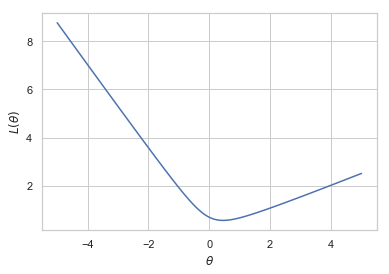

In [14]:
ytmp = np.array([1,1,0,0,1,0])
xtmp = np.array([4,3,1,-0.5,-2,-3])

thetas = np.linspace(-5,5,100)
ce_losses = np.array([cross_entropy(t) for t in thetas])
plt.plot(thetas, ce_losses)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$L(\theta)$");

Comparing with the squared loss:

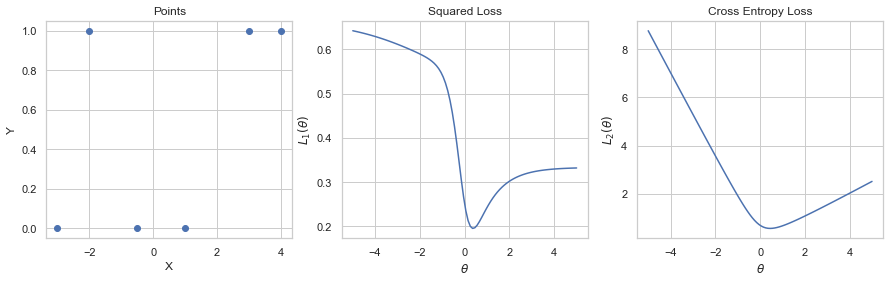

In [15]:
def squared_loss(theta):
    return np.mean((ytmp - sigmoid(theta*xtmp))**2)
sl_losses = np.array([squared_loss(t) for t in thetas])

plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,3,1)
plt.plot(xtmp, ytmp, 'o')
plt.xlabel('X')
plt.ylabel('Y');
ax1.set_title("Points")

ax2 = plt.subplot(1,3,2)
plt.plot(thetas, sl_losses)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$L_1(\theta)$");
ax2.set_title("Squared Loss")

ax3 = plt.subplot(1,3,3)
plt.plot(thetas, ce_losses)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$L_2(\theta)$");
ax3.set_title("Cross Entropy Loss");

we can easily see in the plots that squared loss funtion is not convex while cross entropy is, this is important for our next minimizing step. For a (strictly) convex function on an open set, it has no more than one minimum.  This is quite important since we will use gradient descent algorithm as optimization method to find the minimum of a function.

## Gradient Descent<a name="phase5"></a>
[Return to phase breakdown](#breakdown)

We are interested in creating a function that can minimize a loss function without forcing the user to predetermine which values of $\theta$ to try. As with loss function, we will discuss the intuition for gradient descent first, then formalize our understanding with mathematics, we will use `mean squared loss` as an example, let's say we want to find $argmin\theta$ for a simple dataset $ y=[12.1,12.8,14.9,16.3,17.2]$:

In [16]:
ys = np.array([12.1,12.8,14.9,16.3,17.2])

def mse(theta, y):
    return np.mean((y - theta) ** 2)

def grad_mse(theta, y):
    return -2 * np.mean(y - theta)

def plot_loss(ys, xrange, theta, loss_fn, eps=1e-6):
    thetas = np.arange(xrange[0], xrange[1], 0.05)
    losses = [loss_fn(theta, ys) for theta in thetas]
    loss = loss_fn(theta, ys)
    slope = grad_mse(theta, ys)
    xs = np.arange(theta-1, theta+1, 0.05)
    ys = slope*(xs - theta) + loss
    
    lossplot = go.Scatter(name="MSE", x=thetas, y=losses)
    losspoint = go.Scatter(name="Current Loss", x=[theta], y=[loss], 
                           mode='markers', marker=dict(size=10))
    tangentplot = go.Scatter(name="Tangent Line", x=xs, y=ys,
                            mode='lines', line=dict(dash='dot'))

    return [lossplot, losspoint, tangentplot]

Our first choice of $\theta$ is 12 and 16:

In [21]:
fig = tools.make_subplots(rows=1, cols=2, 
                          subplot_titles=(r'$\theta=12$',r'$\theta=16$'))
for i in plot_loss(ys, [11,18], 12, mse):
    fig.append_trace(i, 1, 1)
for i in plot_loss(ys, [11,18], 16, mse):
    fig.append_trace(i, 1, 2)
    
fig['layout'].update(showlegend=False, title='MSE')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



When $\theta = 12$, we want to choose a new $\theta$ to decrease the loss, so we look at the slope of the loss function, and the slope is negative, which means that increasing $\theta$ will decrease the loss. At next we choose a new $\theta = 16$ on the other hand, and the slope of the loss function is positive, which means that decreasing the $\theta$ will decrease the loss. 

The slope of the loss function tells us how to move $\theta$ to decrease the loss. When the slope is negative, we should increase the $\theta$ while on the other hand we should decrease it. Mathematically, we write:

$$\theta^{(t+1)} = \theta^{(t)} - \frac{\partial}{\partial \theta} L(\theta^{(t)}, \textbf{y})$$

Where $ \theta^{(t)} $ is the current estimate and $ \theta^{(t+1)} $ is the next estimate, $L$ means the loss function and in our example is mean squared loss.

When $ \theta^{(t)} = 12$, we can compute $ \frac{\partial}{\partial \theta} L(\theta^{(t)}, \textbf{y}) = -5.32 $. Thus, $ \theta^{(t+1)} = 12 - (-5.32) = 17.32 $:

In [23]:
fig = tools.make_subplots(rows=1, cols=2, 
                          subplot_titles=(r'$\theta=12$',r'$\theta=17.32$'))
for i in plot_loss(ys, [11,18], 12, mse):
    fig.append_trace(i, 1, 1)
for i in plot_loss(ys, [11,18], 17.32, mse):
    fig.append_trace(i, 1, 2)
    
fig['layout'].update(showlegend=False, title='MSE')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



Although $\theta$ went in the right direction, it ended up as far away from the minimum as it started. We can remedy this by multiplying the slope by a small constant before subtracting it from $\theta$:

$$\theta^{(t+1)} = \theta^{(t)} - \alpha \cdot \frac{\partial}{\partial \theta} L(\theta^{(t)}, \textbf{y})$$

Where $\alpha$ is a small constant. For example, if we set $\alpha = 0.2$:

In [42]:
thetas = [12]
for i in range(4):
    thetas.append(thetas[i] - 0.2*grad_mse(thetas[i], ys))

fig = tools.make_subplots(rows=2, cols=2, 
                          subplot_titles=(r'$\theta={}$'.format(thetas[0]),
                                          r'$\theta={}$'.format(thetas[1]),
                                          r'$\theta={}$'.format(thetas[2]),
                                          r'$\theta={}$'.format(thetas[3])))

for i in plot_loss(ys, [11,18], thetas[0], mse):
    fig.append_trace(i, 1, 1)
for i in plot_loss(ys, [11,18], thetas[1], mse):
    fig.append_trace(i, 1, 2)
for i in plot_loss(ys, [11,18], thetas[2], mse):
    fig.append_trace(i, 2, 1)
for i in plot_loss(ys, [11,18], thetas[3], mse):
    fig.append_trace(i, 2, 2)
    
fig['layout'].update(height=800, width=800, showlegend=False, title='MSE')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



Now finally we have the full algorithm consists of iteratively computing:
$$\large \theta^{(t+1)} \leftarrow \theta^{(t)} - \rho(t) \left(\nabla_\theta \mathbf{L}(\theta) \biggr\rvert_{\theta = \theta^{(\tau)}}\right) $$

Notice
1. We firstly choose a $\theta^{(t)}$, iteratively compute the new $\theta^{(t+1)}$ until it doesn't change anymore.
2. $\rho(t)$ (sometimes called the learning rate) is typically: $\rho(t) = \frac{1}{t}$. Sometimes people tend to start with a larger $\rho(t)$ and decrease it over time.
3. $ \nabla_\theta L(\theta^{(t)}, \textbf{y}) $ is the partial derivative / gradient of the loss function with respect to $ \theta $ at time $t$.

You can see know the importance of choosing a convex loss function: $\nabla_\theta \mathbf{L}(\theta) \biggr\rvert_{\theta = \theta^{(\tau)}}$ is an essential part of the gradient descent algorithm.

### Gradient Descent for Logistic Regression

Let's recall our simplified average cross entropy:

$$ \arg \min_\theta -\frac{1}{n} \sum_{i=1}^n \left( y_i \phi(x_i)^T \theta + \log \left(\sigma\left(-\phi(x_i)^T \theta\right) \right) \right) $$

Take derivative:

$$\nabla_\theta \textbf{L}(\theta) = -\frac{1}{n} \sum_{i=1}^n \left(\nabla_\theta y_i \phi(x_i)^T \theta + \nabla_\theta\log \left(\sigma\left(-\phi(x_i)^T \theta\right) \right) \right)$$

$$=-\frac{1}{n} \sum_{i=1}^n \left(y_i \phi(x_i) + \nabla_\theta\log \left(\sigma\left(-\phi(x_i)^T \theta\right) \right) \right)$$


$$=-\frac{1}{n} \sum_{i=1}^n \left(y_i \phi(x_i) + \frac{1}{\sigma(-\phi(x_i)^T \theta) }\left(\nabla_\theta\sigma\left(-\phi(x_i)^T \theta\right) \right) \right)$$

$$=-\frac{1}{n} \sum_{i=1}^n \left(y_i \phi(x_i) + \frac{\sigma(-\phi(x_i)^T \theta)}{\sigma(-\phi(x_i)^T \theta) }\sigma(\phi(x_i)^T \theta)\nabla_\theta\left(-\phi(x_i)^T \theta\right) \right) \text{Useful Identity: $\frac{\partial}{\partial t}\sigma(t) = \sigma(t)\sigma(-t)$}$$

$$=-\frac{1}{n} \sum_{i=1}^n (y_i - \sigma(\phi(x_i)^T \theta))\phi(x_i)$$

So the gradient of the loss is given by: $$\large \nabla_\theta \textbf{L}(\theta) = \frac{1}{n}\sum_{i=1}^n \left(\sigma\left(\phi(x_i)^T \theta\right) - y_i \right) \phi(x_i) $$

The logistic regression update equation is then: $$\large \theta^{(t+1)} \leftarrow \theta^{(t)} - \frac{1}{t} \left(\frac{1}{n}\sum_{i=1}^n \left(\sigma\left(\phi(x_i)^T \theta\right) - y_i \right) \phi(x_i)\right) $$